## SVM

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
housing_price = pd.read_csv("kc_house_data.csv")

## 전처리
df_preprocessed = housing_price.drop(["id", "date", "price"], axis = 1)\
.assign(date = pd.to_datetime(housing_price.date)).assign(price = housing_price.price)

## scores recoding
scoring_dict = dict()

In [3]:
def month_days_split(df_train : pd.DataFrame, df_test : pd.DataFrame) :
    """
    train/test set에서 `date` 열을 월별과 일별로 따로 분석하기 위한 함수
    """
    test_month = df_test.date.dt.month.astype(str)
    test_days = df_test.date.map(lambda x : x - df_preprocessed.date.min()).dt.days
    train_month = df_train.date.dt.month.astype(str)
    train_days = df_train.date.map(lambda x : x - df_preprocessed.date.min()).dt.days
    
    return [train_month, train_days], [test_month, test_days]

df_train, df_test = train_test_split(df_preprocessed, test_size = 0.3, shuffle = True, random_state = 14107)
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

train_date, test_date = month_days_split(df_train, df_test)

In [4]:
import matplotlib.pyplot as plt

In [21]:
kfold = KFold(5, random_state=0, shuffle=True)
grid = GridSearchCV(svm_rbf, {'C':[0.1,1,10,100,1000], 'gamma':[0.5,1,2,3,4]}, refit=True, cv=kfold, scoring='accuracy')
grid.fit(X, y)
grid.best_params_

{'C': 1000, 'gamma': 4}

In [43]:
best_svm = SVC(kernel="rbf", gamma=4, C=1000)
best_svm.fit(X, y)

SVC(C=1000, gamma=4)

In [ ]:
fig, ax = plt.figure()

disp = DecisionBoundaryDisplay.from_estimator(
        best_svm,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax
)

ax.scatter(X.long, X.lat, c = y, cmap = plt.cm.coolwarm, s = 20, edgecolors = "k")
ax.set_xlim([X.long.min(), X.long.max()])
ax.set_ylim([X.lat.min(), X.lat.max()])
ax.set_title(title)

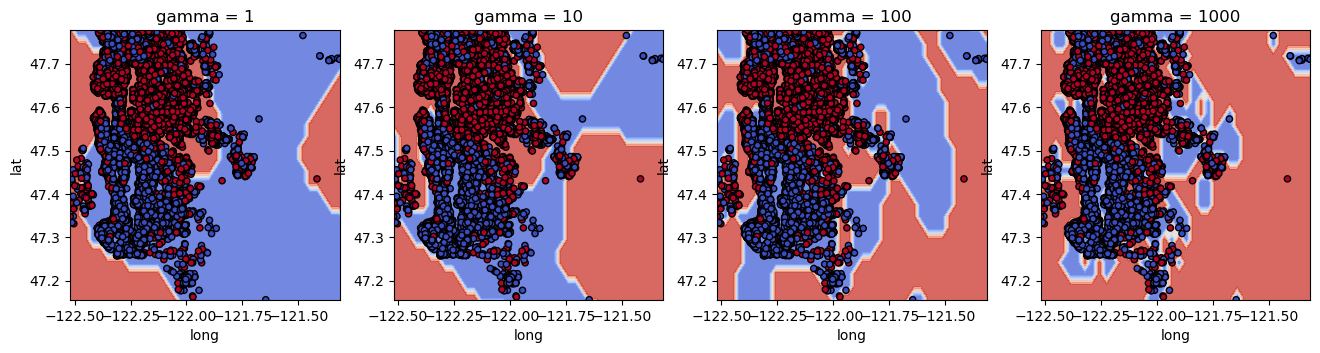

In [13]:
models = [SVC(kernel='rbf', gamma = i, C = 10000) for i in [1, 10, 100, 1000]]
models = [clf.fit(X, y) for clf in models]
gammas = [1, 10, 100, 1000]
titles = [f"gamma = {i}" for i in gammas]

fig, axs = plt.subplots(1, 4, figsize = (16, 3.5))

for clf, title, ax in zip(models, titles, axs.flatten()) :
        disp = DecisionBoundaryDisplay.from_estimator(
                clf,
                X,
                response_method="predict",
                cmap=plt.cm.coolwarm,
                alpha=0.8,
                ax=ax
        )

        ax.scatter(X.long, X.lat, c = y, cmap = plt.cm.coolwarm, s = 20, edgecolors = "k")
        ax.set_xlim([X.long.min(), X.long.max()])
        ax.set_ylim([X.lat.min(), X.lat.max()])
        ax.set_title(title)

Truth,0,1
Predicted,,
0,2450,542
1,769,2723


In [6]:
## 반응변수 구간 분할
X = df_train[["long", "lat"]]
y = df_train.price.map(lambda x : x >= df_train.price.median()).astype(int)

XX = df_test[["long", "lat"]]
yy = df_test.price.map(lambda x : x >= df_train.price.median()).astype(int)

## hyperparameter tuning
svm_rbf = SVC()
kfold = KFold(5, random_state=0, shuffle=True)

grid = GridSearchCV(svm_rbf, {'C': [1000, 5000, 10000], 'gamma': 10**np.linspace(0, 3, 5)}, refit=True, cv=kfold, scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)

{'C': 10000, 'gamma': 1000.0}

In [17]:
print(f"accuracy = {np.mean(yy == yyhat)}")

accuracy = 0.8386798272671191


In [18]:
best_svm = grid.best_estimator_
yyhat = best_svm.predict(XX)
print(confusion_matrix(yyhat, yy))
print(f"accuracy = {np.mean(yy == yyhat)}")

[[2655  482]
 [ 564 2783]]
accuracy = 0.8386798272671191


In [14]:
yy.sum()

3265

In [ ]:
best_svm = SVC(c = 10000, gamma = 1000)
yyhat = best_svm.predict(XX)
print(confusion_matrix(yyhat, yy))
print(f"accuracy = {np.mean(yy == yyhat)}")

In [ ]:
import pickle

with open("best_svm.pkl", "wb") as f :
    pickle.dump(best_svm)

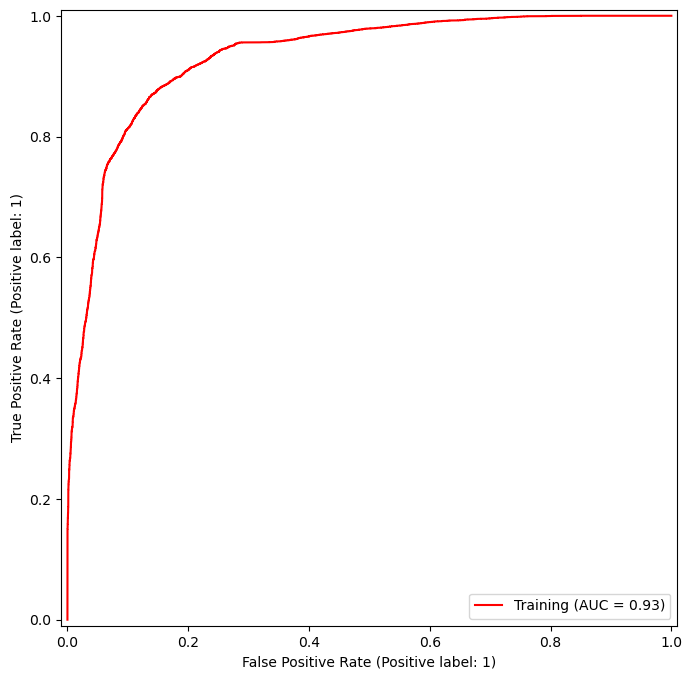

In [19]:
roc_curve = RocCurveDisplay.from_estimator

fig, ax = plt.subplots(figsize=(8,8))
roc_curve(best_svm, XX, yy, name='SVM test', color='r', ax=ax)
fig.show()

범위 너무 욕심부리지 말고, 10만까지만 하자...

예측 성능을 XGBoost랑 로지스틱 회귀분석을 이용하여 비교할 수도 있음. 근데 이러면 또 최적화해야 하니까 귀찮아서 그냥 안할래...

In [5]:
## 반응변수 구간 분할
X = df_train[["long", "lat"]]
y = df_train.price.map(lambda x : x >= df_train.price.median()).astype(int)

XX = df_test[["long", "lat"]]
yy = df_test.price.map(lambda x : x >= df_train.price.median()).astype(int)

## hyperparameter tuning
svm_rbf = SVC()
kfold = KFold(2, random_state=0, shuffle=True)

grid = GridSearchCV(svm_rbf, {'C': np.logspace(1, 5, 5), 'gamma': np.logspace(1, 5, 5)}, refit=True, cv=kfold, scoring='accuracy', verbose = 2)
grid.fit(X, y)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV] END .................................C=10.0, gamma=10.0; total time=   3.3s
[CV] END .................................C=10.0, gamma=10.0; total time=   3.0s
[CV] END ................................C=10.0, gamma=100.0; total time=   2.8s
[CV] END ................................C=10.0, gamma=100.0; total time=   2.7s
[CV] END ...............................C=10.0, gamma=1000.0; total time=   2.7s
[CV] END ...............................C=10.0, gamma=1000.0; total time=   2.7s
[CV] END ..............................C=10.0, gamma=10000.0; total time=   3.9s
[CV] END ..............................C=10.0, gamma=10000.0; total time=   3.9s
[CV] END .............................C=10.0, gamma=100000.0; total time=   7.3s
[CV] END .............................C=10.0, gamma=100000.0; total time=   7.0s
[CV] END ................................C=100.0, gamma=10.0; total time=   3.6s
[CV] END ................................C=100.0

GridSearchCV(cv=KFold(n_splits=2, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid={'C': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
                         'gamma': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])},
             scoring='accuracy', verbose=2)

In [6]:
best_svm = grid.best_estimator_
yyhat = best_svm.predict(XX)
print(confusion_matrix(yyhat, yy))
print(f"accuracy = {np.mean(yy == yyhat)}")

[[2613  441]
 [ 606 2824]]
accuracy = 0.8385256014805675


`-` XGBoost와의 비교

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import RocCurveDisplay, confusion_matrix
from skopt import BayesSearchCV
import xgboost as xgb

In [ ]:
## data
X = df_train[["long", "lat"]]
y = df_train.price.map(lambda x : x >= df_train.price.median()).astype(int)

XX = df_test[["long", "lat"]]
yy = df_test.price.map(lambda x : x >= df_train.price.median()).astype(int)

## params
fit_params = {
    'early_stopping_rounds': 10, ## 성능 개선이 없을 시 종료 라운드
    'verbose': False
}

search_space = {
    'learning_rate': (0.001, 0.1), ## 학습률
    'n_estimators': (100, 1000), ## 트리 수
    'gamma': (1e-1, 10000, "log-uniform"), ## 노드 분할 시 최소 손실 감소량
    'max_depth': (1, 10), ## 트리 깊이
    'min_child_weight': (1e-2, 100, "log-uniform"), ## 헤시안의 최소값
    'colsample_bytree': (0.2, 0.7), ## 각 트리 구성 시 사용하는 열의 비율
    'subsample': (0.5, 1.0), ## 데이터 서브 샘플링
    'sampling_method': ["uniform", "gradient_based"], ## 서브 샘플링 방법
    'lambda': (1e-1, 10000, "log-uniform"), ## 가중치 L2 표준화 계수
    'alpha': (1e-2, 1000, "log-uniform") ## 가중치 L1 표준화 계수
}

kfold = KFold(4, random_state = 14107, shuffle = True)

## optimizr
predictr = xgb.XGBClassifier(tree_method = "gpu_hist", device = "cuda")
optimizr = BayesSearchCV(
    estimator=predictr,
    search_spaces=search_space,
    fit_params=fit_params,
    cv=kfold,
    scoring="accuracy",
    random_state=14107,
    verbose=1
)

optimizr.fit(X, y)

In [ ]:
import pickle

with open("best_svm.pkl", "wb") as f :
    pickle.dump(best_svm)

In [ ]:
## best parameter set 확인
# print(optimizr.best_estimator_.get_params())

## rmse 계산
best_predictr = xgb.XGBRegressor(**optimizr.best_estimator_.get_params())
best_predictr.fit(X, y)

In [ ]:
import pickle

with open("best_svm.pkl", "wb") as f :
    pickle.dump(best_svm)

In [81]:
grid_df

,C,gamma,error_rate
1,1.0,1.0,0.212176
2,1.0,2.0,0.187587
3,1.0,3.0,0.171195
4,1.0,4.0,0.173111
5,1.0,5.0,0.203517
6,2.0,1.0,0.208937
7,2.0,2.0,0.187984
8,2.0,3.0,0.169542
9,2.0,4.0,0.187917
10,2.0,5.0,0.216009


In [66]:
param_grid = grid.cv_results_["params"]
error_rates = 1 - grid.cv_results_["mean_test_score"]

grid_df = pd.DataFrame({"C" : [], "gamma" : []})

for i, r in enumerate(param_grid) :
    grid_df.loc[i+1] = r

grid_df = grid_df.assign(error_rate = error_rates)

grid_df["C"] = grid_df.C.map(lambda x : np.log10(x))
grid_df["gamma"] = grid_df.gamma.map(lambda x : np.log10(x))

In [96]:
plt.rcParams['font.family'] ='NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:5: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_3038172/2872560135.py:5: SyntaxWarning: invalid escape sequence '\g'
  ax.set_ylabel("log($\gamma$)", fontdict = fontlabel, labelpad = 16)


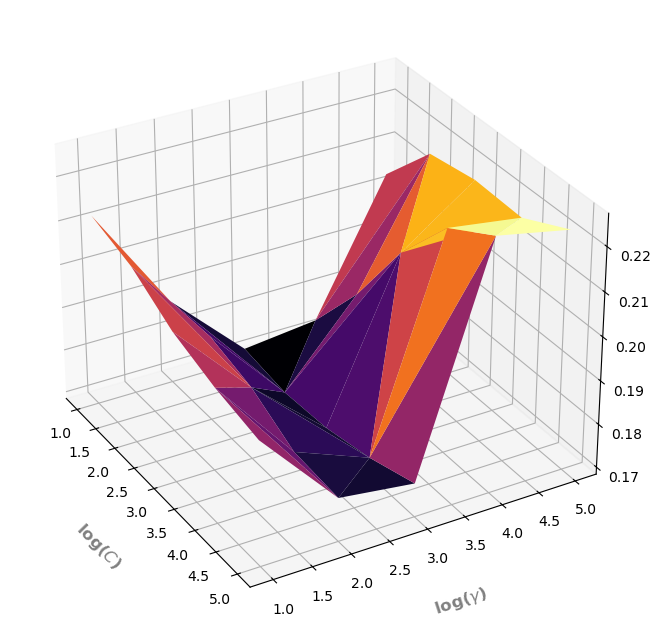

In [80]:
fig, ax = plt.subplots(figsize = (8, 8), subplot_kw = {"projection" : "3d"})
fontlabel = {"fontsize":"large", "color":"gray", "fontweight":"bold"}

ax.set_xlabel("log($C$)", fontdict = fontlabel, labelpad = 16)
ax.set_ylabel("log($\gamma$)", fontdict = fontlabel, labelpad = 16)
ax.set_zlabel("error rate", fontdict = fontlabel, labelpad = 16)

ax.plot_trisurf(grid_df["C"], grid_df["gamma"], grid_df["error_rate"], cmap = "inferno")
ax.view_init(elev=30., azim=-30)

In [107]:
from matplotlib.colors import Normalize
from matplotlib import cm

<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:17: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_3038172/717720584.py:17: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xlabel('$log(\gamma)$')


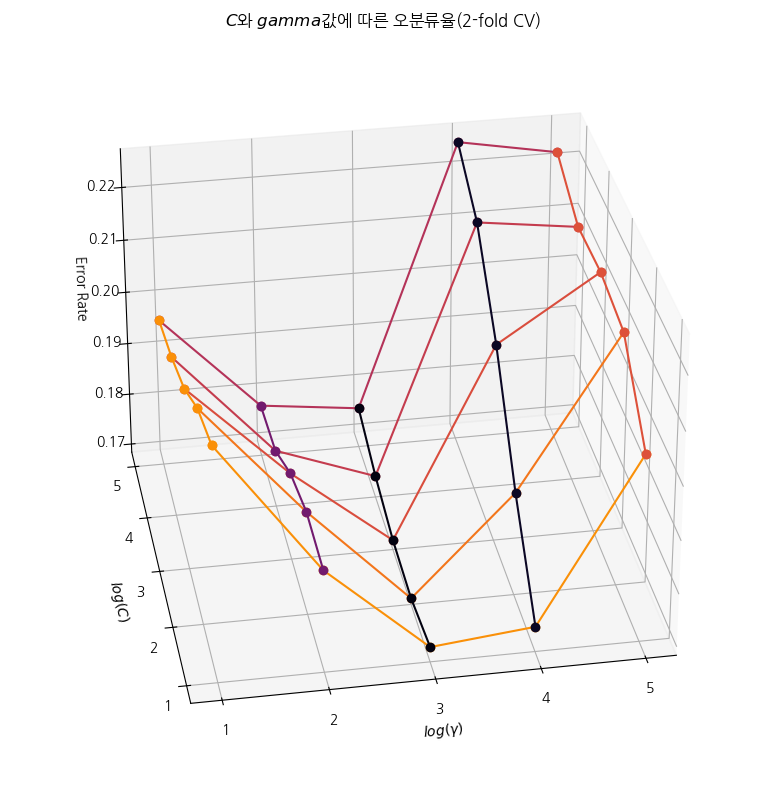

In [113]:
## 색상표 설정
cmap = cm.inferno
norm = Normalize(vmin=grid_df['error_rate'].min(), vmax=grid_df['error_rate'].max())

fig, ax = plt.subplots(figsize = (8, 8), subplot_kw = {"projection" : "3d"})

## C 고정, gamma 변화에 따른 선분 추가
for c in sorted(grid_df['C'].unique()):
    subset = grid_df[grid_df['C'] == c]
    colors = cmap(norm(subset['error_rate']))
    ax.plot(subset['gamma'], [c] * len(subset), subset['error_rate'], marker='o', color = colors[0], markerfacecolor = colors[0])

## gamma 고정, C 변화에 따른 선분 추가
for gamma in sorted(grid_df['gamma'].unique()):
    subset = grid_df[grid_df['gamma'] == gamma]
    colors = cmap(norm(subset['error_rate']))
    ax.plot([gamma] * len(subset), subset['C'], subset['error_rate'], marker='o', color = colors[0], markerfacecolor = colors[0])

## 축 및 제목 설정
ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('$log(C)$')
ax.set_zlabel('Error Rate')
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_title('$C$와 $gamma$값에 따른 오분류율(2-fold CV)')
ax.view_init(elev=30., azim=-100)
plt.tight_layout()
plt.show()